## Extract Entities

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.experimental.components.schema import SchemaFromTextExtractor

The code uses the SchemaFromTextExtractor class to extract a schema from a given text input.

The extractor:

1. Creates a prompt instructing the LLM to:

a. Identify entities and relationships in any given text

b. Format the output as JSON

2. Passes the prompt and text to the LLM for processing

3. Parses the JSON response to create a schema object

Given the text, "Neo4j is a graph database management system (GDBMS) developed by Neo4j Inc.", a simplified version of the extracted schema would be:

```
node_types=(
    NodeType(label='GraphDatabase),
    NodeType(label='Company')
)
relationship_types=(
    RelationshipType(label='DEVELOPED_BY'),
)
patterns=(
    ('GraphDatabaseManagementSystem', 'DEVELOPED_BY', 'Company')
)
```


In [3]:
schema_extractor = SchemaFromTextExtractor(
    llm=OpenAILLM(
        model_name="gpt-4",
        model_params={"temperature": 0}
    )
)

text = """
Neo4j is a graph database management system (GDBMS) developed by Neo4j Inc.
"""

# Extract the schema from the text using asyncio.run
extracted_schema = await schema_extractor.run(text=text)

print(extracted_schema)

node_types=(NodeType(label='Company', description='', properties=[PropertyType(name='name', type='STRING', description='', required=False)], additional_properties=False), NodeType(label='DatabaseManagementSystem', description='', properties=[PropertyType(name='name', type='STRING', description='', required=False)], additional_properties=False)) relationship_types=(RelationshipType(label='DEVELOPED_BY', description='', properties=[], additional_properties=True),) patterns=(('DatabaseManagementSystem', 'DEVELOPED_BY', 'Company'),) additional_node_types=False additional_relationship_types=False additional_patterns=False


In [4]:
type(extracted_schema)

neo4j_graphrag.experimental.components.schema.GraphSchema

Experiment with different text inputs to see how the schema extraction varies based on the content provided, for example:

- "Python is a programming language created by Guido van Rossum."

- "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France."

- "Large Language Models (LLMs) are a type of artificial intelligence model designed to understand and generate human-like text."

When you have experimented with the schema extraction, you can continue.

In [5]:
text = """
Large Language Models (LLMs) are a type of artificial intelligence model designed to understand and generate human-like text.
"""

# Extract the schema from the text using asyncio.run
extracted_schema = await schema_extractor.run(text=text)

print(extracted_schema)

node_types=(NodeType(label='ArtificialIntelligenceModel', description='', properties=[PropertyType(name='type', type='STRING', description='', required=False)], additional_properties=False), NodeType(label='Text', description='', properties=[PropertyType(name='humanLike', type='BOOLEAN', description='', required=False)], additional_properties=False)) relationship_types=(RelationshipType(label='DESIGNED_TO', description='', properties=[], additional_properties=True), RelationshipType(label='UNDERSTANDS_AND_GENERATES', description='', properties=[], additional_properties=True)) patterns=(('ArtificialIntelligenceModel', 'DESIGNED_TO', 'Text'), ('ArtificialIntelligenceModel', 'UNDERSTANDS_AND_GENERATES', 'Text')) additional_node_types=False additional_relationship_types=False additional_patterns=False


## Create a graph

In this lesson, you will learn how to create a knowledge graph from unstructured data using the SimpleKGPipeline class.

The SimpleKGPipeline class provides a pipeline which implements a series of steps to create a knowledge graph from unstructured data:

1. Load the text

2. Split the text into chunks

3. Create embeddings for each chunk

4. Extract entities from the chunks

5. Write the data to a Neo4j database

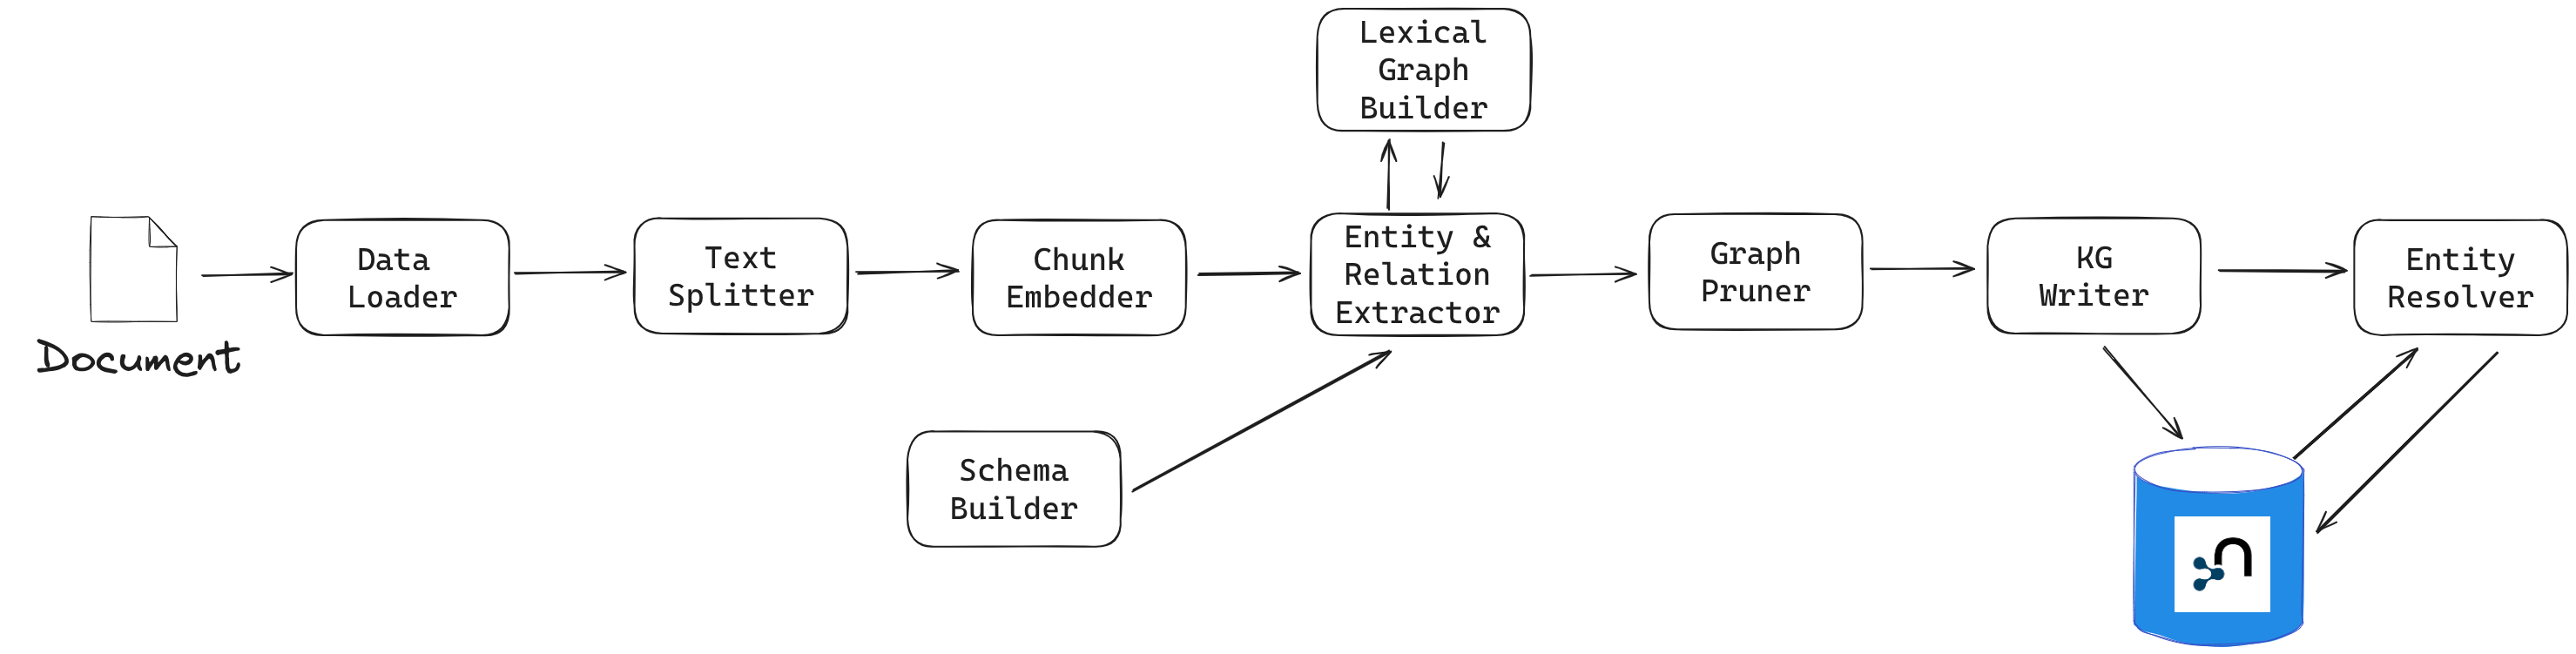

In [6]:
from neo4j import GraphDatabase
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline

neo4j_driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)
neo4j_driver.verify_connectivity()

In [7]:
llm = OpenAILLM(
    model_name="gpt-4o",
    model_params={
        "temperature": 0,
        "response_format": {"type": "json_object"},
    }
)

In [8]:
embedder = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)


In [10]:
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
)

In [11]:
pdf_file = "./assets/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"
result = await kg_builder.run_async(file_path=pdf_file)
print(result.result)

{'resolver': {'number_of_nodes_to_resolve': 17, 'number_of_created_nodes': 7}}


The SimpleKGPipeline creates the following default graph model:

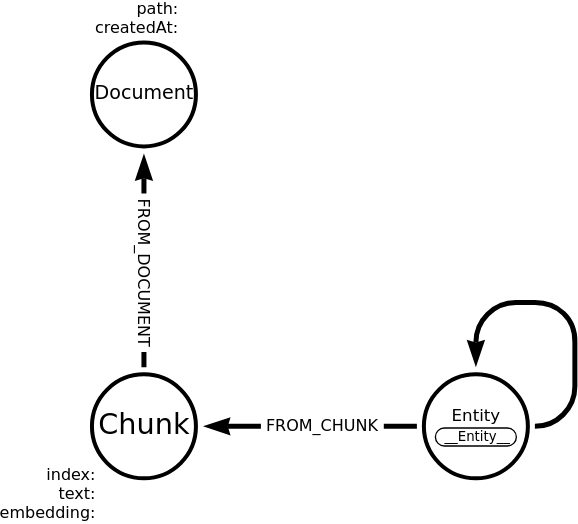


a graph model showing `(Document)<[:FROM_DOCUMENT]-(Chunk)←[:FROM_CHUNK]-(Entity)`

The Entity nodes represent the entities extracted from the text chunks. Relevant properties are extracted from the chunk and associated with the entity nodes.

You can view the documents and chunks created in the graph using the following Cypher query:

In [12]:
from neo4j import GraphDatabase
from utils import execute_query

neo4j_uri = os.getenv("NEO4J_URI")
neo4j_user = os.getenv("NEO4J_USERNAME")
neo4j_pass = os.getenv("NEO4J_PASSWORD")
neo4j_db = os.getenv("NEO4J_DATABASE")

neo4j_driver = GraphDatabase.driver(neo4j_uri, auth=(neo4j_user, neo4j_pass))

query = """
MATCH (d:Document)<-[:FROM_DOCUMENT]-(c:Chunk)
RETURN d.path, c.text
"""

execute_query(neo4j_driver, query)

[{'d.path': './assets/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf',
  'c.text': '= What is Generative AI\n:order: 1\n:type: lesson\n:slides: true\n[.slide]\n== GenAI\nGenerative AI (or GenAI) refers to artificial intelligence systems\ndesigned to create new content that resembles human-made data. The data\ncould be text, images, audio, or code.\n[.transcript-only]\n====\nThese models, like GPT (for text) or DALL-E (for images), are trained on\nlarge datasets and use patterns learned from this data to generate new\noutput.\n====\nimage::images/genai-model-process.svg[A diagram showing the process of\nGenerative AI, where a model is trained on a large dataset, learns\npatterns, and generates new content based on those patterns.]\n[.transcript-only]\n====\nGenerative AI is widely used in applications such as chatbots, content\ncreation, image synthesis, and code generation.\n====\n[.slide.discrete]\n== GenAI\nGenerative AI models are not "intelligent" in the way humans are:\n. 

## Chunk size

The graph created by the SimpleKGPipeline is based on chunks of text extracted from the documents. By default, the chunk size is quite large, which may result in fewer, larger chunks. **Larger chunks provide more context for entity extraction but result in less granular data**

In this lesson, you will modify the `SimpleKGPipeline` to use a different chunk size.

### Delete the existing graph

You will be re-importing the data and modifying the existing graph. To ensure a clean state, you can delete the graph at any time using:

In [13]:
query = """
MATCH (n) DETACH DELETE n
"""

execute_query(neo4j_driver, query)

[]

### Text Splitter Chunk Size

To modify the chunk size you will need to create a `FixedSizeSplitter` object and pass it to the SimpleKGPipeline when creating the pipeline instance:

**Chunk size and overlap**

The `chunk_size` parameter defines the maximum number of characters in each text chunk. The `chunk_overlap` parameter ensures that there is some overlap between consecutive chunks, which can help maintain context.

In [15]:
from neo4j_graphrag.experimental.components.text_splitters.fixed_size_splitter import FixedSizeSplitter

text_splitter = FixedSizeSplitter(chunk_size=500, chunk_overlap=100)

In [16]:
kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    text_splitter=text_splitter,
)

In [17]:
result = await kg_builder.run_async(file_path=pdf_file)
print(result.result)

{'resolver': {'number_of_nodes_to_resolve': 15, 'number_of_created_nodes': 8}}


In [18]:
query = """
MATCH (d:Document)<-[:FROM_DOCUMENT]-(c:Chunk)
RETURN d.path, c.index, c.text
ORDER BY d.path, c.index
"""

execute_query(neo4j_driver, query)

[{'d.path': './assets/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf',
  'c.index': 0,
  'c.text': '= What is Generative AI\n:order: 1\n:type: lesson\n:slides: true\n[.slide]\n== GenAI\nGenerative AI (or GenAI) refers to artificial intelligence systems\ndesigned to create new content that resembles human-made data. The data\ncould be text, images, audio, or code.\n[.transcript-only]\n====\nThese models, like GPT (for text) or DALL-E (for images), are trained on\nlarge datasets and use patterns learned from this data to generate new\noutput.\n====\nimage::images/genai-model-process.svg[A diagram showing the '},
 {'d.path': './assets/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf',
  'c.index': 1,
  'c.text': 'this data to generate new\noutput.\n====\nimage::images/genai-model-process.svg[A diagram showing the process of\nGenerative AI, where a model is trained on a large dataset, learns\npatterns, and generates new content based on those patterns.]\n[.transcript-only]\n=

## Define a schema

The knowledge graph you created is unconstrained, meaning that any entity or relationship can be created based on the data extracted from the text. This can lead to graphs that are non-specific and may be difficult to analyze and query.

In this lesson, you will modify the SimpleKGPipeline to use a custom schema for the knowledge graph.

### Schema

When you provide a schema to the `SimpleKGPipeline`, it will pass this information to the LLM instructing it to only identify those nodes and relationships. This allows you to create a more structured and meaningful knowledge graph.

You define a schema by expressing the desired nodes, relationships, or patterns you want to extract from the text.

For example, you might want to extract the following information:

- nodes - `Person`, `Organization`, `Location`

- relationships - `WORKS_AT`, `LOCATED_IN`

- patterns - `(Person)-[WORKS_AT]→(Organization)`, `(Organization)-[LOCATED_IN]→(Location)`

**Iterate your schema**

You don’t have to define nodes, relationships, and patterns all at once. You can start with just nodes or just relationships and expand your schema as needed.

For example, if you only define nodes, the LLM will find any relationships between those nodes based on the text.

This approach can help you iteratively build and refine your knowledge graph schema.

### Nodes

You define the NODES as a list of node labels and pass the list to the SimpleKGPipeline when creating the pipeline instance.

**Define relevant nodes**

You should define the node labels that are relevant to your domain and the information you want to extract from the text.

```python
NODE_TYPES = [
    "Technology",
    "Concept",
    "Example",
    "Process",
]

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    text_splitter=text_splitter,
    schema={
        "node_types": NODE_TYPES,
    },
)

pdf_file = "./genai-graphrag-python/data/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"
result = asyncio.run(kg_builder.run_async(file_path=pdf_file))
print(result.result)
```

You can also provide a description for each node label and associated properties to help guide the LLM when extracting entities.

```python
NODE_TYPES = [
    "Technology",
    "Concept",
    "Example",
    "Process",
    "Challenge",
    {"label": "Benefit", "description": "A benefit or advantage of using a technology or approach."},
    {
        "label": "Resource",
        "description": "A related learning resource such as a book, article, video, or course.",
        "properties": [
            {"name": "name", "type": "STRING", "required": True}, 
            {"name": "type", "type": "STRING"}
        ]
    },
]
```

### Relationships

You express required relationship types by providing a list of relationship types to the `SimpleKGPipeline`.

```python
RELATIONSHIP_TYPES = [
    "RELATED_TO",
    "PART_OF",
    "USED_IN",
    "LEADS_TO",
    "HAS_CHALLENGE",
    "LEADS_TO",
    "CITES"
]
```

You can also provide patterns that define how nodes types are connected by relationships.

```python
PATTERNS = [
    ("Technology", "RELATED_TO", "Technology"),
    ("Concept", "RELATED_TO", "Technology"),
    ("Example", "USED_IN", "Technology"),
    ("Process", "PART_OF", "Technology"),
    ("Technology", "HAS_CHALLENGE", "Challenge"),
    ("Concept", "HAS_CHALLENGE", "Challenge"),
    ("Technology", "LEADS_TO", "Benefit"),
    ("Process", "LEADS_TO", "Benefit"),
    ("Resource", "CITES", "Technology"),
]
```

Nodes, relationships and patterns are all passed to the `SimpleKGPipeline` as the schema when creating the pipeline:

In [20]:
query = """
MATCH (n) DETACH DELETE n
"""

execute_query(neo4j_driver, query)

[]

In [21]:
NODE_TYPES = [
    "Technology",
    "Concept",
    "Example",
    "Process",
    "Challenge",
    {"label": "Benefit", "description": "A benefit or advantage of using a technology or approach."},
    {
        "label": "Resource",
        "description": "A related learning resource such as a book, article, video, or course.",
        "properties": [
            {"name": "name", "type": "STRING", "required": True}, 
            {"name": "type", "type": "STRING"}
        ]
    },
]

RELATIONSHIP_TYPES = [
    "RELATED_TO",
    "PART_OF",
    "USED_IN",
    "LEADS_TO",
    "HAS_CHALLENGE",
    "LEADS_TO",
    "CITES"
]

PATTERNS = [
    ("Technology", "RELATED_TO", "Technology"),
    ("Concept", "RELATED_TO", "Technology"),
    ("Example", "USED_IN", "Technology"),
    ("Process", "PART_OF", "Technology"),
    ("Technology", "HAS_CHALLENGE", "Challenge"),
    ("Concept", "HAS_CHALLENGE", "Challenge"),
    ("Technology", "LEADS_TO", "Benefit"),
    ("Process", "LEADS_TO", "Benefit"),
    ("Resource", "CITES", "Technology"),
]

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    text_splitter=text_splitter,
    schema={
        "node_types": NODE_TYPES,
        "relationship_types": RELATIONSHIP_TYPES,
        "patterns": PATTERNS
    },
)

pdf_file = "./assets/genai-fundamentals_1-generative-ai_1-what-is-genai.pdf"
result = await kg_builder.run_async(file_path=pdf_file)
print(result.result)

{'resolver': {'number_of_nodes_to_resolve': 35, 'number_of_created_nodes': 28}}


## Process all the documents

When you are happy with the schema, you can modify the program to process all the PDF documents from the [Neo4j and Generative AI Fundamentals course](https://graphacademy.neo4j.com/courses/genai-fundamentals):

```python
data_path = "./genai-graphrag-python/data/"
pdf_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.pdf')]

for pdf_file in pdf_files:

    print(f"Processing {pdf_file}")
    result = asyncio.run(kg_builder.run_async(file_path=pdf_file))
    print(result.result)
```

**OpenAI Rate Limiting?**

When using a free OpenAI API key, you may encounter rate limiting issues when processing multiple documents. You can add a `sleep` between document processing to mitigate this.

## Add structured data to the knowledge graph

The knowledge graph you created is solely based on unstructured data extracted from documents. You may have access to structured data sources such as databases, CSV files, or APIs that contain valuable information relevant to your domain.

Combining the structured and unstructured data can enhance the knowledge graph’s richness and usefulness.

**Lexical and Domain Graphs**

The unstructured part of your graph is known as the [Lexical Graph](https://graphrag.com/reference/knowledge-graph/lexical-graph/), while the structured part is known as the [Domain Graph](https://graphrag.com/reference/knowledge-graph/domain-graph/).

### Load from CSV file

The repository contains a sample CSV file `genai-graphrag-python/data/docs.csv` which contains metadata about the lessons the documents were created from.

```
filename,course,module,lesson,url
genai-fundamentals_1-generative-ai_1-what-is-genai.pdf,genai-fundamentals,1-generative-ai,1-what-is-genai,https://graphacademy.neo4j.com/courses/genai-fundamentals/1-generative-ai/1-what-is-genai
genai-fundamentals_1-generative-ai_2-considerations.pdf,genai-fundamentals,1-generative-ai,2-considerations,https://graphacademy.neo4j.com/courses/genai-fundamentals/1-generative-ai/2-considerations
...
```

You can use the CSV file as input and a structured data source when creating the knowledge graph.

```python
import os
from dotenv import load_dotenv
load_dotenv()

import asyncio
import csv

from neo4j import GraphDatabase
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings
from neo4j_graphrag.experimental.pipeline.kg_builder import SimpleKGPipeline
from neo4j_graphrag.experimental.components.text_splitters.fixed_size_splitter import FixedSizeSplitter

neo4j_driver = GraphDatabase.driver(
    os.getenv("NEO4J_URI"),
    auth=(os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))
)
neo4j_driver.verify_connectivity()

llm = OpenAILLM(
    model_name="gpt-4o",
    model_params={
        "temperature": 0,
        "response_format": {"type": "json_object"},
    }
)

embedder = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

text_splitter = FixedSizeSplitter(chunk_size=500, chunk_overlap=100)

NODE_TYPES = [
    "Technology",
    "Concept",
    "Example",
    "Process",
    "Challenge",
    {"label": "Benefit", "description": "A benefit or advantage of using a technology or approach."},
    {
        "label": "Resource",
        "description": "A related learning resource such as a book, article, video, or course.",
        "properties": [
            {"name": "name", "type": "STRING", "required": True}, 
            {"name": "type", "type": "STRING"}
        ]
    },
]

RELATIONSHIP_TYPES = [
    "RELATED_TO",
    "PART_OF",
    "USED_IN",
    "LEADS_TO",
    "HAS_CHALLENGE",
    "LEADS_TO",
    "CITES"
]

PATTERNS = [
    ("Technology", "RELATED_TO", "Technology"),
    ("Concept", "RELATED_TO", "Technology"),
    ("Example", "USED_IN", "Technology"),
    ("Process", "PART_OF", "Technology"),
    ("Technology", "HAS_CHALLENGE", "Challenge"),
    ("Concept", "HAS_CHALLENGE", "Challenge"),
    ("Technology", "LEADS_TO", "Benefit"),
    ("Process", "LEADS_TO", "Benefit"),
    ("Resource", "CITES", "Technology"),
]

kg_builder = SimpleKGPipeline(
    llm=llm,
    driver=neo4j_driver, 
    neo4j_database=os.getenv("NEO4J_DATABASE"), 
    embedder=embedder, 
    from_pdf=True,
    text_splitter=text_splitter,
    schema={
        "node_types": NODE_TYPES,
        "relationship_types": RELATIONSHIP_TYPES,
        "patterns": PATTERNS
    },
)

data_path = "./genai-graphrag-python/data/"

docs_csv = csv.DictReader(
    open(os.path.join(data_path, "docs.csv"), encoding="utf8", newline='')
)

cypher = """
MATCH (d:Document {path: $pdf_path})
MERGE (l:Lesson {url: $url})
SET l.name = $lesson,
    l.module = $module,
    l.course = $course
MERGE (d)-[:PDF_OF]->(l)
"""

for doc in docs_csv:

    # Create the complete PDF path
    doc["pdf_path"] = os.path.join(data_path, doc["filename"])
    print(f"Processing document: {doc['pdf_path']}")

    # Entity extraction and KG population
    result = asyncio.run(
        kg_builder.run_async(
            file_path=os.path.join(doc["pdf_path"])
        )
    )

    # Create structured graph
    records, summary, keys = neo4j_driver.execute_query(
        cypher,
        parameters_=doc,
        database_=os.getenv("NEO4J_DATABASE")
    )
    print(result, summary.counters)
```

The key differences are:

1. The `docs.csv` file is loaded using `csv.DictReader` to read each row as a dictionary:

```python
data_path = "./genai-graphrag-python/data/"

docs_csv = csv.DictReader(
    open(os.path.join(data_path, "docs.csv"), encoding="utf8", newline='')
)
```

2. The path of the PDF document is constructed using the filename field from the CSV:

```python
# Create the complete PDF path
doc["pdf_path"] = os.path.join(data_path, doc["filename"])
print(f"Processing document: {doc['pdf_path']}")
```

3. A `cypher` statement is defined to create `Lesson` nodes with properties from the CSV data:

```cypher
cypher = """
MATCH (d:Document {path: $pdf_path})
MERGE (l:Lesson {url: $url})
SET l.name = $lesson,
    l.module = $module,
    l.course = $course
MERGE (d)-[:PDF_OF]->(l)
"""
```

The `pdf_path` is used as the key to match the Document nodes created from the PDF files.

4. A Lesson node is created for each document using the cypher statement and the CSV data:

```python
# Create structured graph
records, summary, keys = neo4j_driver.execute_query(
    cypher,
    parameters_=doc,
    database_=os.getenv("NEO4J_DATABASE")
)
```

The resulting knowledge graph will now contain Lesson nodes connected to the Document nodes created from the PDF files:

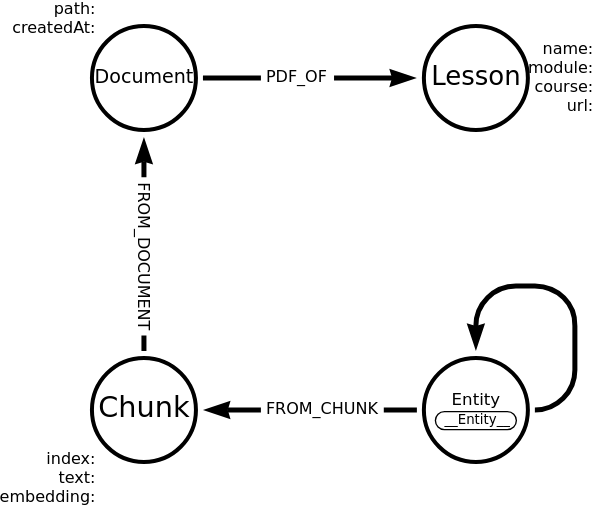

### Explore the structured data

The structured data allows you to query the knowledge graph in new ways.

You can find all lessons that cover a specific technology or concept:

```cypher
MATCH (kg:Technology)
MATCH (kg)-[:FROM_CHUNK]->(c)-[:FROM_DOCUMENT]-(d)-[:PDF_OF]-(l)
WHERE toLower(kg.name) CONTAINS "knowledge graph"
RETURN DISTINCT toLower(kg.name), l.name, l.url
```

The knowledge graph allows you to summarize the content of each lesson by specific categories such as technologies and concepts:

```cypher
MATCH (lesson:Lesson)<-[:PDF_OF]-(:Document)<-[:FROM_DOCUMENT]-(c:Chunk)
RETURN lesson.name,
  [ (c)<-[:FROM_CHUNK]-(tech:Technology) | tech.name ] AS technologies,
  [ (c)<-[:FROM_CHUNK]-(concept:Concept) | concept.name ] AS concepts
```